<a href="https://colab.research.google.com/github/Vikash-exe/Computer-Vision/blob/main/LULC_DL_ViT_Vikash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP 1: Install dependencies
!pip install -q transformers timm accelerate

In [ ]:


# STEP 2: Imports & Settings
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import torch.nn.functional as F

NUM_CLASSES = 6  # Based on remapped mask classes
IMAGE_SIZE = 512
BATCH_SIZE = 4
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Remap your custom class IDs to [0–NUM_CLASSES-1]
original_to_class = {
    1: 0,  # BUILTUP
    2: 1,  # VACANT LAND
    4: 2,  # ROAD
    5: 3,  # SHADOW
    7: 4,  # VEGETATION
    8: 5,  # OTHERS
}




In [ ]:
def remap_mask(mask):
    mask = np.array(mask, dtype=np.uint8)

    remapped = np.full_like(mask, fill_value=255)


    for original_val, new_val in original_to_class.items():
        remapped[mask == original_val] = new_val

    # Convert any leftover 255 (invalid) to 0 or optionally set them to ignore_index in loss
    remapped[remapped == 255] = 0  # Safe default class
    return Image.fromarray(remapped.astype(np.uint8))


In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, processor, limit=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.processor = processor
        self.image_files = sorted([
            f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')
        ])[:limit]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        base_name = os.path.splitext(img_name)[0]
        mask_name = base_name + ".PNG"

        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(img_path).convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE))
        mask = Image.open(mask_path).resize((IMAGE_SIZE, IMAGE_SIZE), Image.NEAREST)
        mask = remap_mask(mask)

        pixel_values = self.processor(images=image, return_tensors="pt").pixel_values.squeeze()
        label = torch.tensor(np.array(mask), dtype=torch.long)

        return pixel_values, label


In [ ]:
# ✅ STEP 1: Mount Google Drive and Unzip Dataset
from zipfile import ZipFile
import os

from google.colab import drive
drive.mount('/content/drive')

# Paths to your uploaded dataset zip file
zip_path = "/content/drive/MyDrive/Dataset.zip"  # Update if needed
extract_path = "/content/dataset"

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_dir = "/content/dataset/images"  # update if needed
mask_dir = "/content/dataset/masks"

processor = SegformerImageProcessor(size=(IMAGE_SIZE, IMAGE_SIZE))

dataset = SegmentationDataset(image_dir, mask_dir, processor, limit=1000)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


In [ ]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=255)


In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True
).to(DEVICE)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([6]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([6, 256, 1, 1]) in the model instantiated
You sho

In [ ]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
# criterion = torch.nn.CrossEntropyLoss()
# train_losses, val_losses = [], []

# for epoch in range(EPOCHS):
#     model.train()
#     total_loss = 0
#     for images, masks in train_loader:
#         images, masks = images.to(DEVICE), masks.to(DEVICE)
#         outputs = model(pixel_values=images).logits
#         outputs = F.interpolate(outputs, size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False)
#         loss = criterion(outputs, masks)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     avg_train = total_loss / len(train_loader)
#     train_losses.append(avg_train)

#     # Validation
#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for images, masks in val_loader:
#             images, masks = images.to(DEVICE), masks.to(DEVICE)
#             outputs = model(pixel_values=images).logits
#             outputs = F.interpolate(outputs, size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False)
#             val_loss += criterion(outputs, masks).item()
#     avg_val = val_loss / len(val_loader)
#     val_losses.append(avg_val)

#     print(f"Epoch {epoch+1}/{EPOCHS} ✅ Train Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f}")


Epoch 1/10 ✅ Train Loss: 1.4881 | Val Loss: 1.1026
Epoch 2/10 ✅ Train Loss: 1.0648 | Val Loss: 0.8784
Epoch 3/10 ✅ Train Loss: 0.9232 | Val Loss: 0.8036
Epoch 4/10 ✅ Train Loss: 0.8321 | Val Loss: 0.7320
Epoch 5/10 ✅ Train Loss: 0.7764 | Val Loss: 0.6998
Epoch 6/10 ✅ Train Loss: 0.7405 | Val Loss: 0.6981
Epoch 7/10 ✅ Train Loss: 0.7028 | Val Loss: 0.6790
Epoch 8/10 ✅ Train Loss: 0.6659 | Val Loss: 0.6593
Epoch 9/10 ✅ Train Loss: 0.6323 | Val Loss: 0.6599
Epoch 10/10 ✅ Train Loss: 0.6097 | Val Loss: 0.6481


In [ ]:
# import torch.nn.functional as F

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, masks in train_loader:
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        outputs = model(pixel_values=images).logits
        outputs = F.interpolate(outputs, size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False)

        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == masks).sum().item()
        total += masks.numel()

    avg_train_loss = total_loss / len(train_loader)
    avg_train_acc = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)

            outputs = model(pixel_values=images).logits
            outputs = F.interpolate(outputs, size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False)

            val_loss += criterion(outputs, masks).item()
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == masks).sum().item()
            val_total += masks.numel()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} ✅ Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}")


Epoch 1/10 ✅ Train Loss: 0.5818, Acc: 0.8143 | Val Loss: 0.6230, Acc: 0.7823
Epoch 2/10 ✅ Train Loss: 0.5531, Acc: 0.8190 | Val Loss: 0.6108, Acc: 0.7820
Epoch 3/10 ✅ Train Loss: 0.5530, Acc: 0.8194 | Val Loss: 0.6325, Acc: 0.7805
Epoch 4/10 ✅ Train Loss: 0.5175, Acc: 0.8313 | Val Loss: 0.5877, Acc: 0.7932
Epoch 5/10 ✅ Train Loss: 0.4946, Acc: 0.8378 | Val Loss: 0.5990, Acc: 0.7912
Epoch 6/10 ✅ Train Loss: 0.4876, Acc: 0.8378 | Val Loss: 0.5851, Acc: 0.7960
Epoch 7/10 ✅ Train Loss: 0.4647, Acc: 0.8458 | Val Loss: 0.6373, Acc: 0.7777
Epoch 8/10 ✅ Train Loss: 0.4877, Acc: 0.8381 | Val Loss: 0.5918, Acc: 0.7939
Epoch 9/10 ✅ Train Loss: 0.4572, Acc: 0.8459 | Val Loss: 0.6235, Acc: 0.7865
Epoch 10/10 ✅ Train Loss: 0.4568, Acc: 0.8455 | Val Loss: 0.6034, Acc: 0.7924


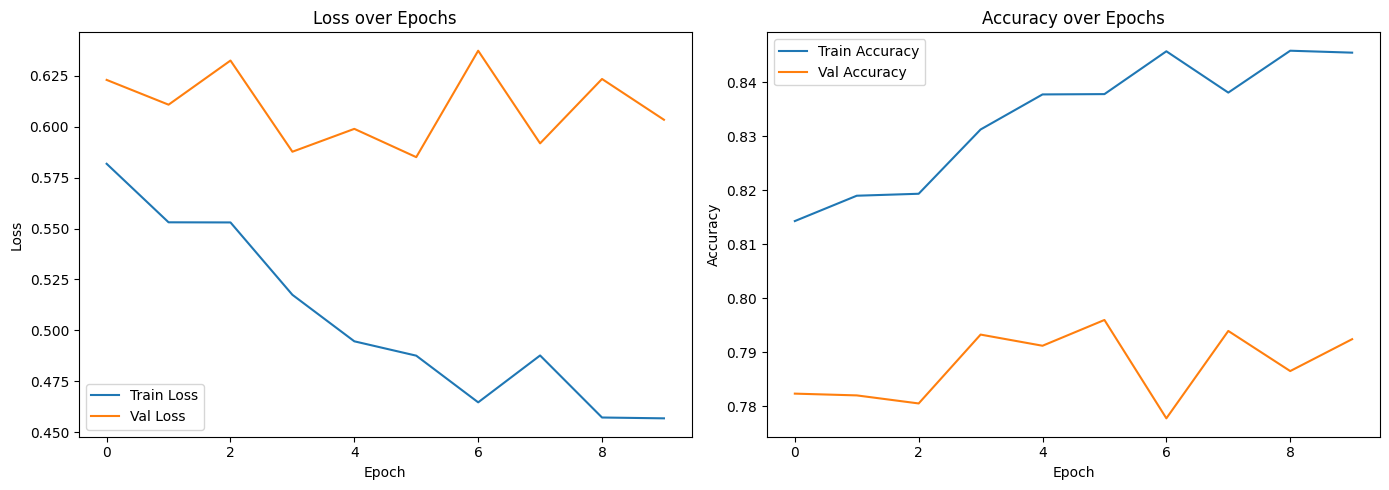

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# ✅ Call this after training:
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)


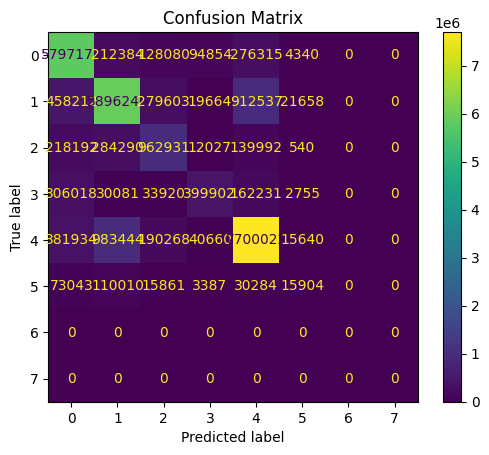

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)

            outputs = model(pixel_values=images).logits
            outputs = F.interpolate(outputs, size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False)

            preds = torch.argmax(outputs, dim=1)

            y_true.extend(masks.cpu().view(-1).numpy())
            y_pred.extend(preds.cpu().view(-1).numpy())

    cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='viridis', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

# ✅ Call this after training:
plot_confusion_matrix(model, val_loader)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Optional: Custom colormap for 8 classes
custom_cmap = plt.get_cmap("tab20", NUM_CLASSES)

def visualize_prediction(model, dataset, index, processor=None):
    model.eval()

    # Get one sample from dataset
    image, true_mask = dataset[index]
    image = image.to(DEVICE).unsqueeze(0)

    if processor:
        pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(DEVICE)
    else:
        pixel_values = image  # if already preprocessed

    # Predict
    with torch.no_grad():
        logits = model(pixel_values=pixel_values).logits
        logits = F.interpolate(logits, size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False)
        pred_mask = torch.argmax(logits, dim=1)[0].cpu().numpy()

    # Convert tensors to displayable format
    image_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # Normalize to [0,1]

    true_mask_np = true_mask.cpu().numpy()

    # Plot
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask_np, cmap=custom_cmap, vmin=0, vmax=NUM_CLASSES-1)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap=custom_cmap, vmin=0, vmax=NUM_CLASSES-1)
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


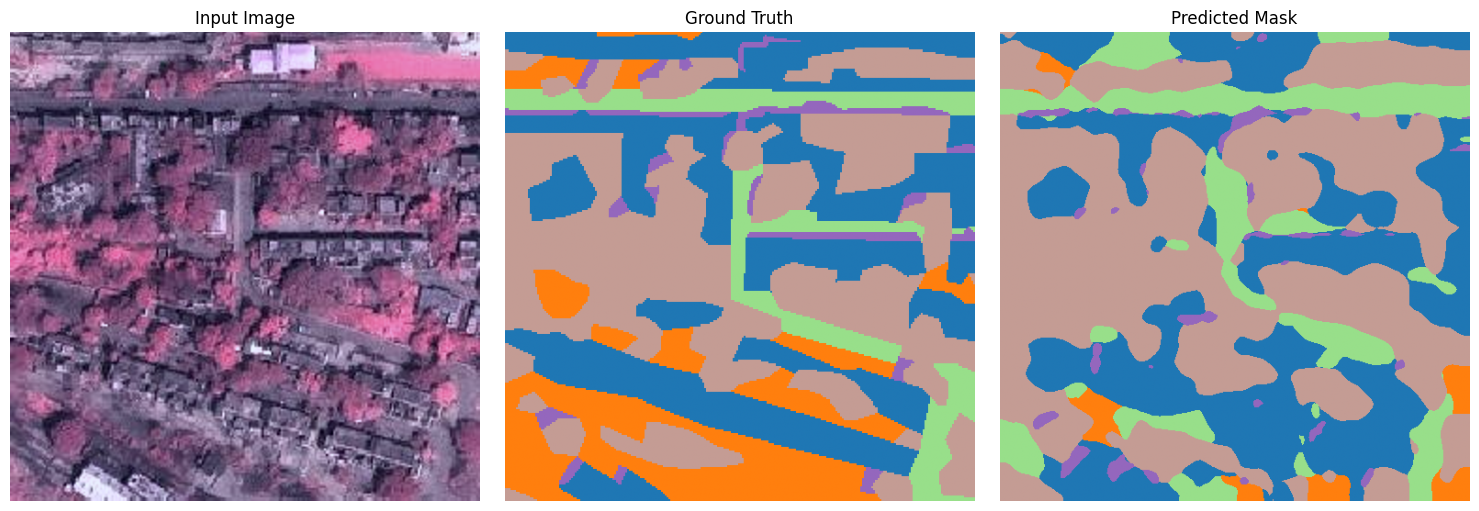

In [ ]:
# Show prediction for a specific image index from your validation set
visualize_prediction(model, val_dataset, index=5)
